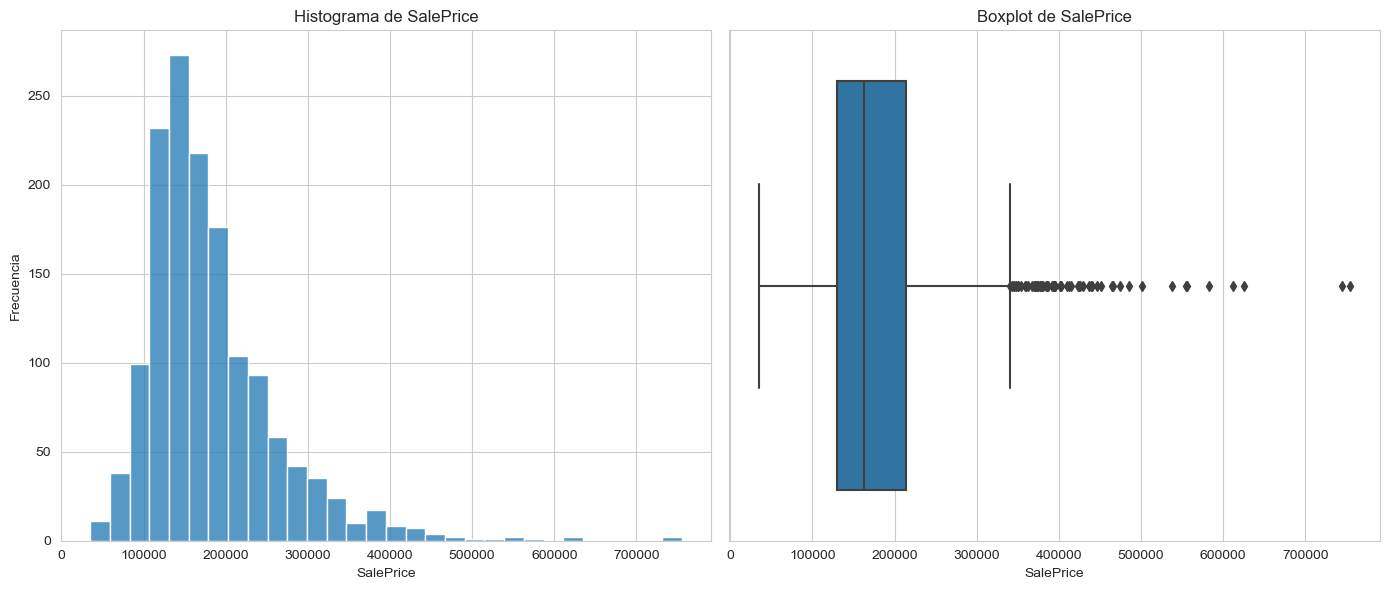

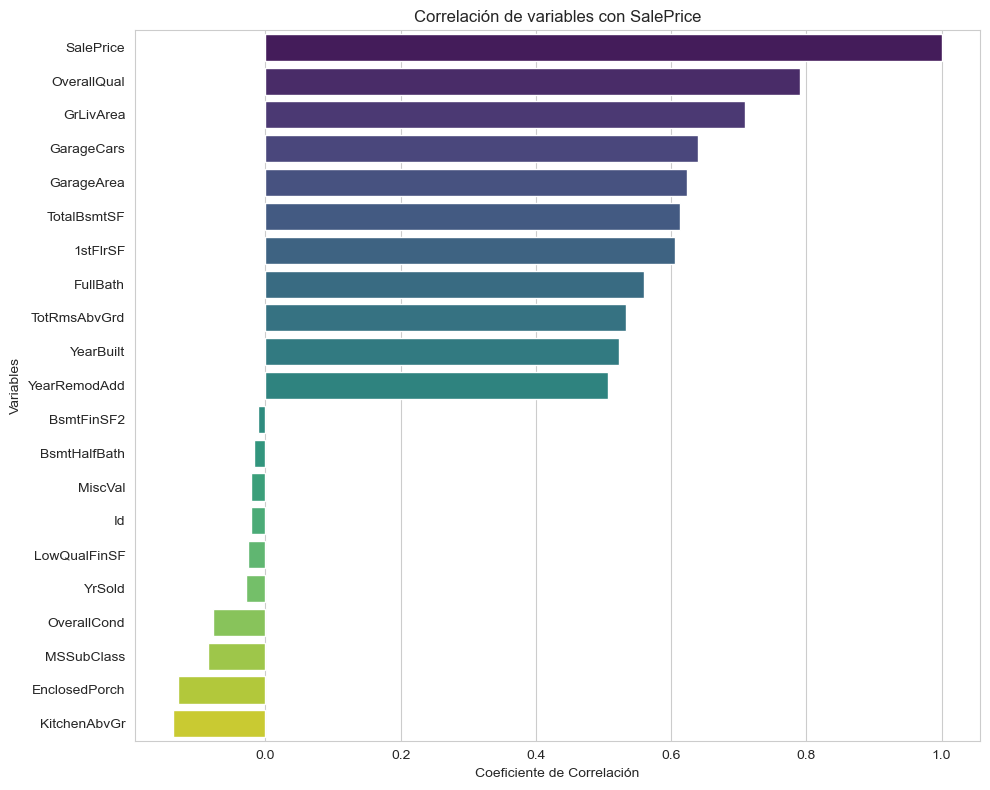

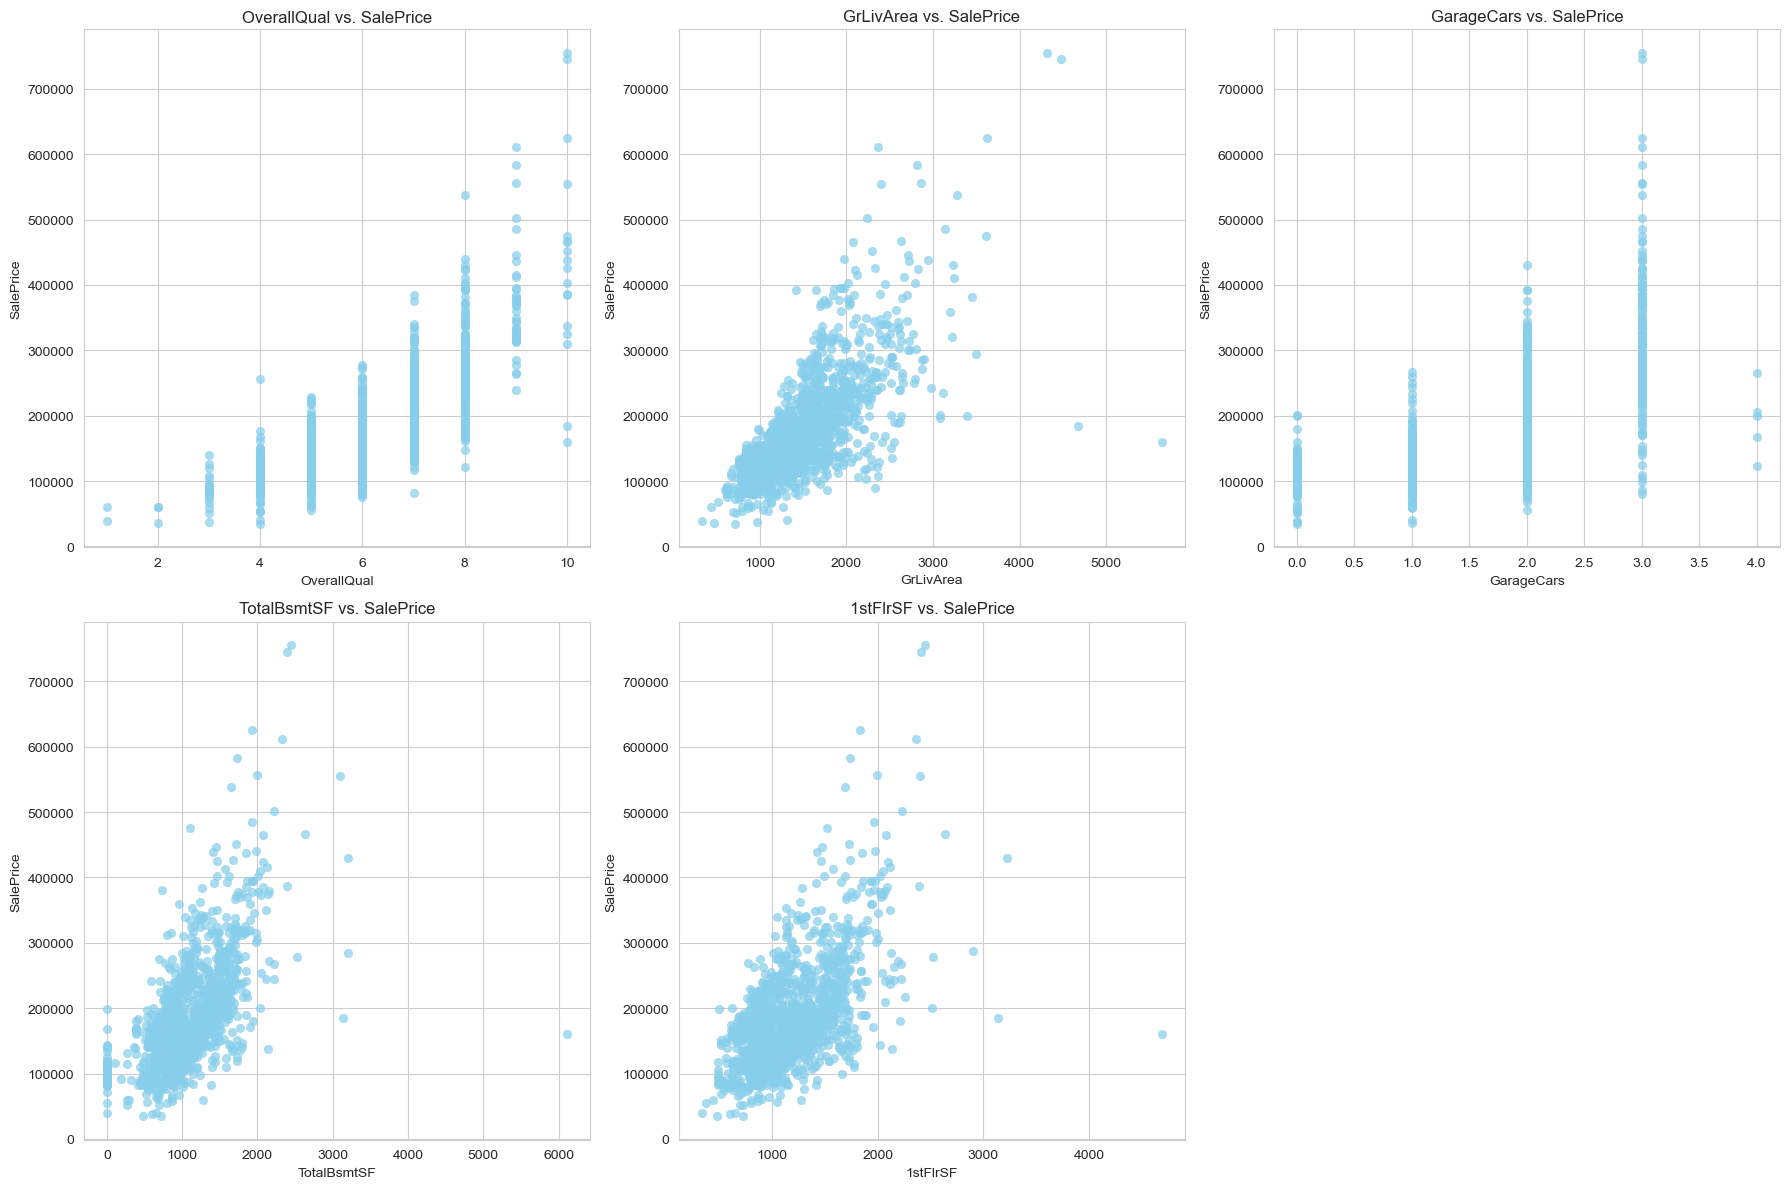

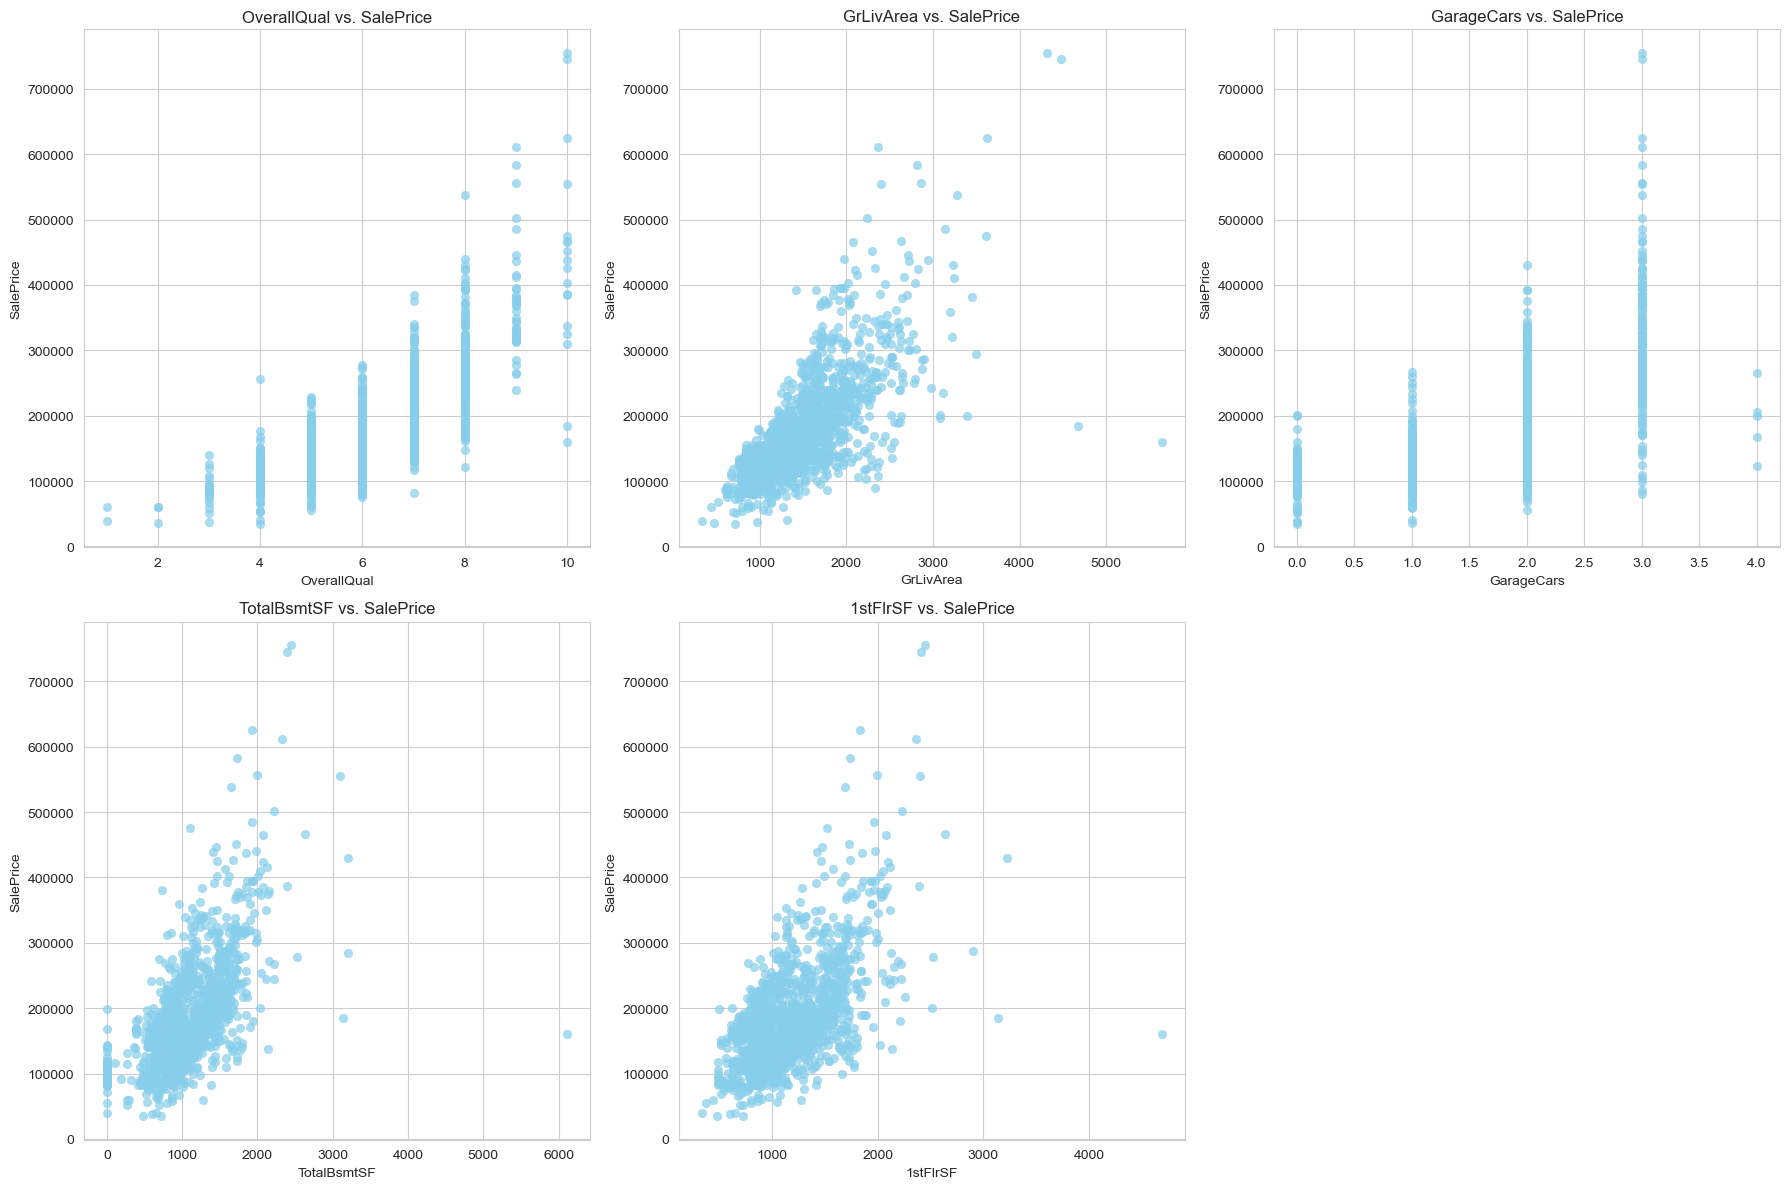

C:\Users\Tony\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212952794573.79932, tolerance: 743224265.6625475
  model = cd_fast.sparse_enet_coordinate_descent(


'predictions.csv'

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(train_data['SalePrice'], bins=30, kde=False, ax=ax[0])
ax[0].set_title('Histograma de SalePrice')
ax[0].set_xlabel('SalePrice')
ax[0].set_ylabel('Frecuencia')

sns.boxplot(x=train_data['SalePrice'], ax=ax[1])
ax[1].set_title('Boxplot de SalePrice')
ax[1].set_xlabel('SalePrice')

plt.tight_layout()
plt.show()

correlations = train_data.select_dtypes(include=[np.number]).corr()['SalePrice'].sort_values(ascending=False)

top_corr = pd.concat([correlations.head(11), correlations.tail(10)])

plt.figure(figsize=(10, 8))

sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")

plt.title('Correlación de variables con SalePrice')
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('Variables')

plt.tight_layout()
plt.show()

top_corr

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
ax = ax.flatten()

variables_to_plot = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']

for i, var in enumerate(variables_to_plot):
    sns.scatterplot(x=var, y='SalePrice', data=train_data, ax=ax[i], color='skyblue', edgecolor=None, alpha=0.7)
    ax[i].set_title(f'{var} vs. SalePrice')
    ax[i].set_xlabel(var)
    ax[i].set_ylabel('SalePrice')

ax[-1].axis('off')
plt.tight_layout()
plt.show()

missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_percentage = (missing_values / len(train_data)) * 100

missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

missing_data.head(10)

nan_to_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
               'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
               'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
nan_to_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
               'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

train_data[nan_to_none] = train_data[nan_to_none].fillna('None')
train_data[nan_to_zero] = train_data[nan_to_zero].fillna(0)

train_data['LotFrontage'] = train_data['LotFrontage'].fillna(train_data['LotFrontage'].median())

remaining_nan = train_data.isnull().sum()
remaining_nan = remaining_nan[remaining_nan > 0]

remaining_nan

train_data['MasVnrType'] = train_data['MasVnrType'].fillna('None')
train_data['Electrical'] = train_data['Electrical'].fillna(train_data['Electrical'].mode()[0])

train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(0)

remaining_nan = train_data.isnull().sum().max()

remaining_nan == 0

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
ax = ax.flatten()

variables_to_plot = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']

for i, var in enumerate(variables_to_plot):
    sns.scatterplot(x=var, y='SalePrice', data=train_data, ax=ax[i], color='skyblue', edgecolor=None, alpha=0.7)
    ax[i].set_title(f'{var} vs. SalePrice')
    ax[i].set_xlabel(var)
    ax[i].set_ylabel('SalePrice')

ax[-1].axis('off')
plt.tight_layout()
plt.show()

outliers_idx = []

outliers_idx.extend(train_data[(train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 300000)].index.tolist())

outliers_idx.extend(train_data[(train_data['GarageCars'] == 4) & (train_data['SalePrice'] < 300000)].index.tolist())

outliers_idx.extend(train_data[train_data['TotalBsmtSF'] > 6000].index.tolist())

train_data_cleaned = train_data.drop(index=outliers_idx).reset_index(drop=True)

train_data.shape, train_data_cleaned.shape

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_cols = train_data_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_data_cleaned.select_dtypes(include=['object']).columns.tolist()

numeric_cols.remove('SalePrice')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X = train_data_cleaned.drop(columns='SalePrice')
y = train_data_cleaned['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

(X_train.shape, X_val.shape), (y_train.shape, y_val.shape)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import numpy as np

model = make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
train_r2 = r2_score(y_train, train_preds)
val_r2 = r2_score(y_val, val_preds)

(train_rmse, train_r2), (val_rmse, val_r2)

from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

results = {}

for model_name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    val_preds = pipeline.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    val_r2 = r2_score(y_val, val_preds)
    results[model_name] = {'RMSE': val_rmse, 'R2': val_r2}

results_df = pd.DataFrame(results).T

results_df.sort_values(by='RMSE', ascending=True)

final_model = make_pipeline(preprocessor, Ridge())
final_model.fit(X, y)

test_preds = final_model.predict(test_data)

predictions_df = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': test_preds})

predictions_df.head()

predictions_filepath = 'predictions.csv'
predictions_df.to_csv(predictions_filepath, index=False)

predictions_filepath

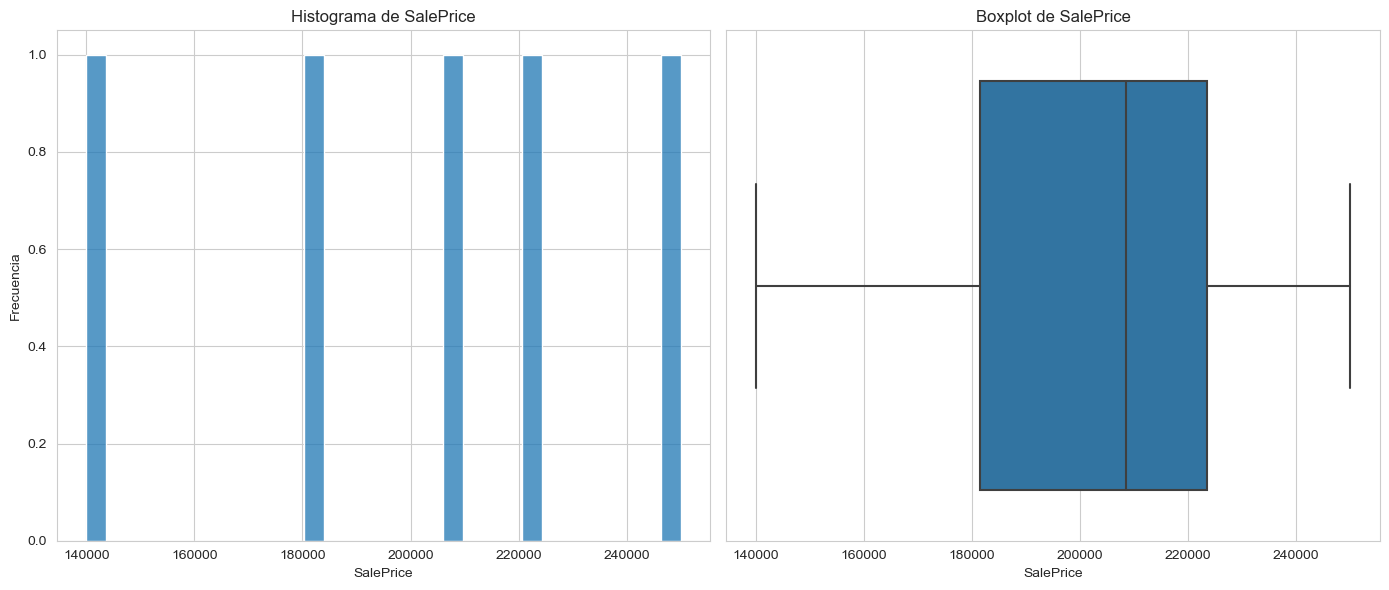

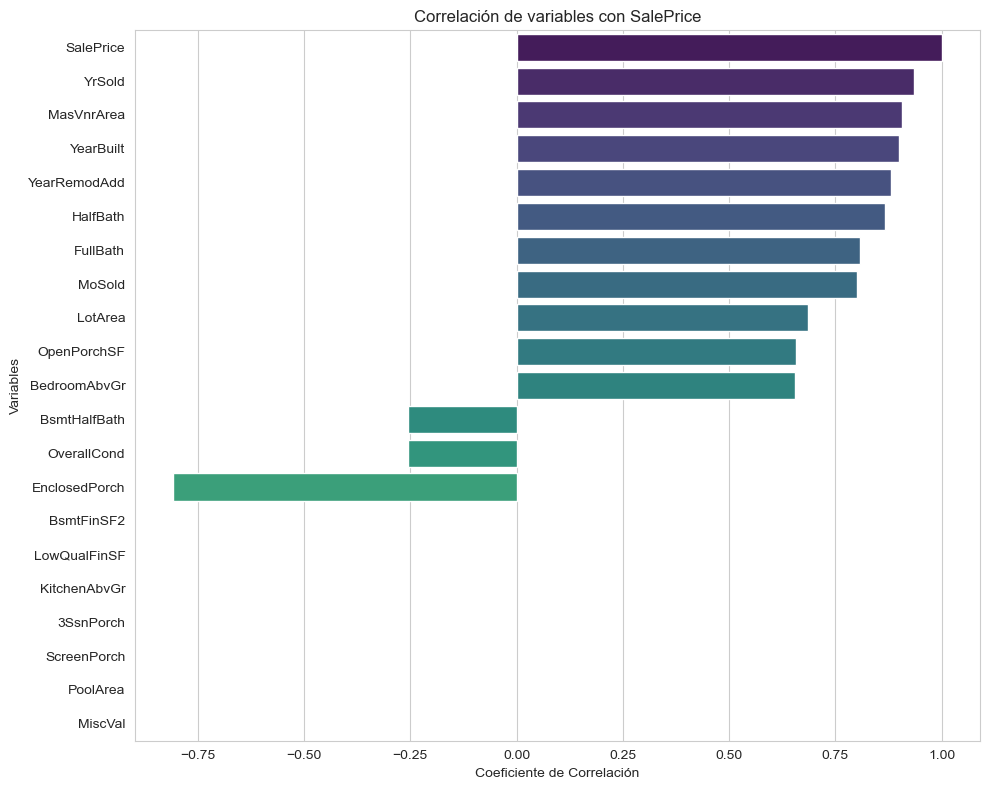

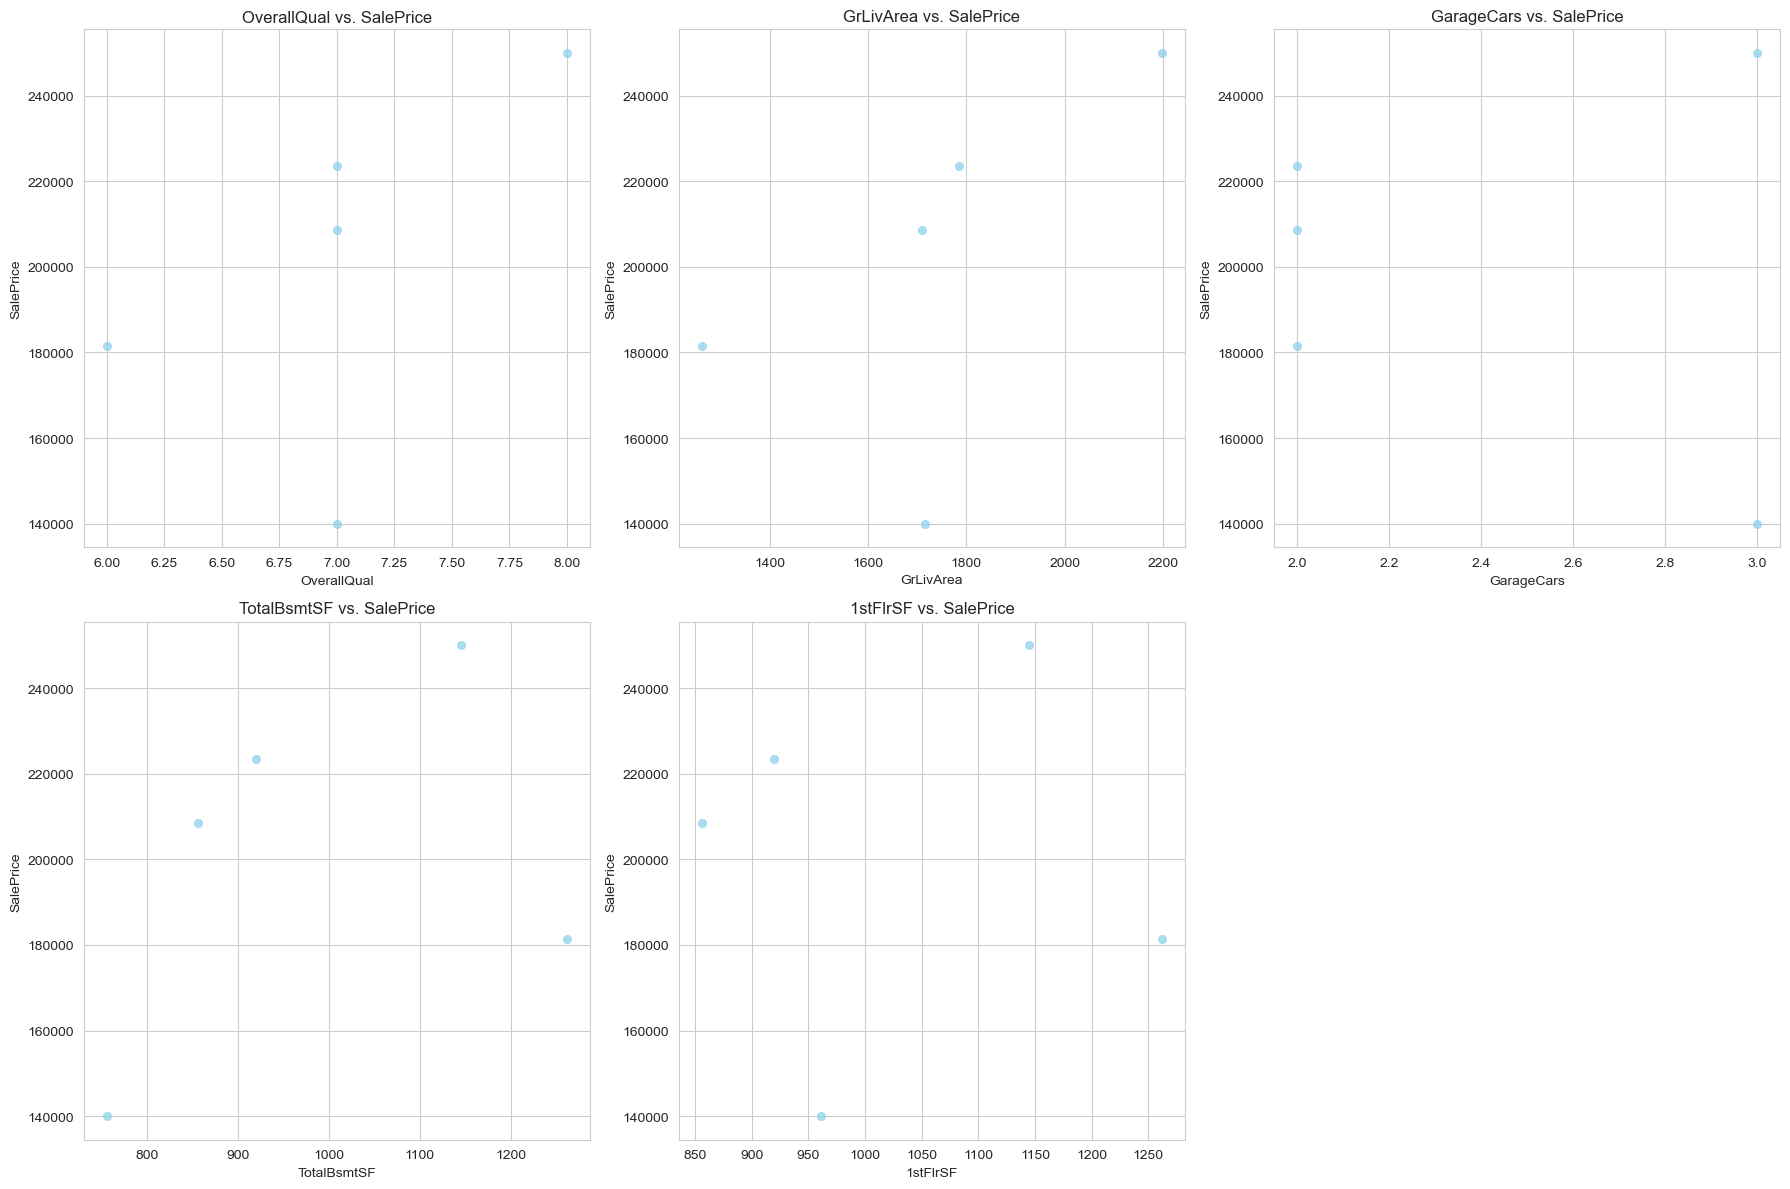

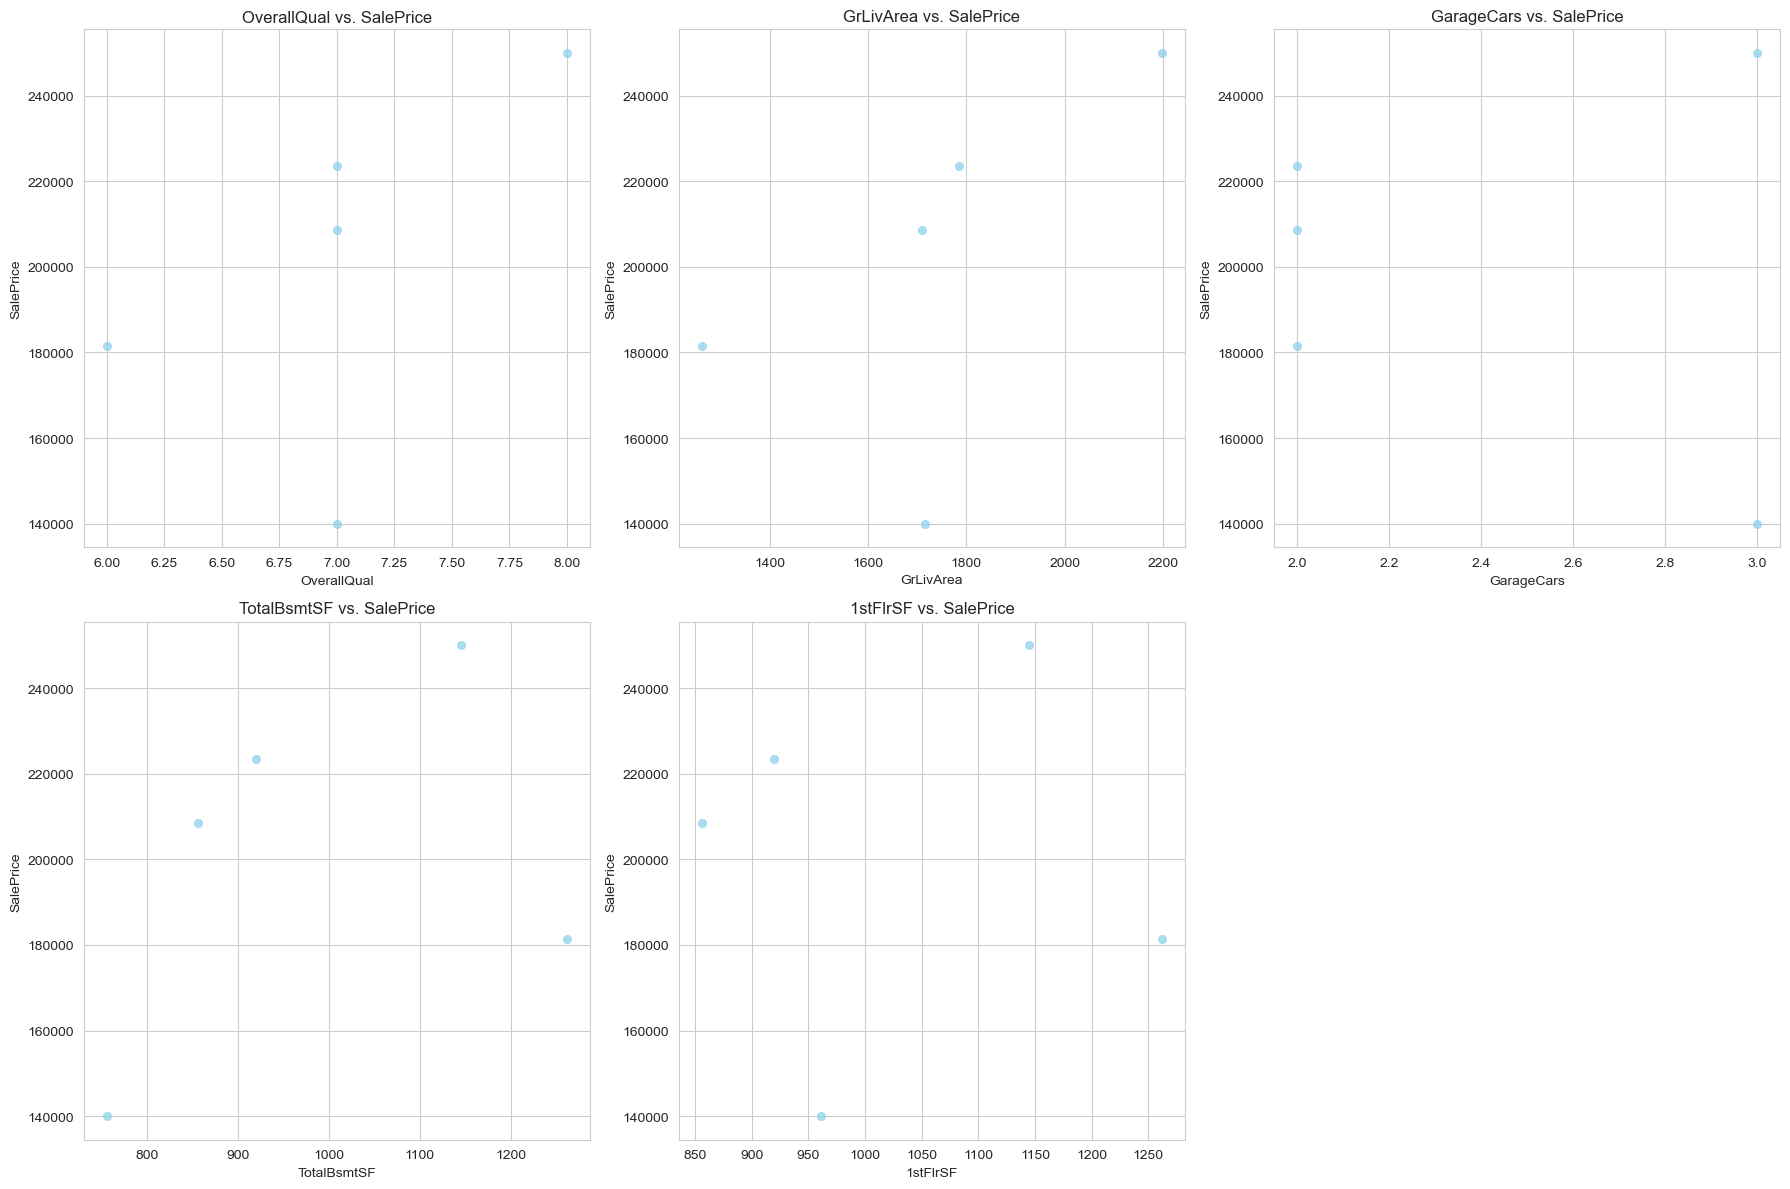

C:\Users\Tony\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Tony\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Tony\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Tony\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Tony\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg,

'predictions5.csv'

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


train_data = pd.read_csv("train.csv").head(5)
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(train_data['SalePrice'], bins=30, kde=False, ax=ax[0])
ax[0].set_title('Histograma de SalePrice')
ax[0].set_xlabel('SalePrice')
ax[0].set_ylabel('Frecuencia')

sns.boxplot(x=train_data['SalePrice'], ax=ax[1])
ax[1].set_title('Boxplot de SalePrice')
ax[1].set_xlabel('SalePrice')

plt.tight_layout()
plt.show()

correlations = train_data.select_dtypes(include=[np.number]).corr()['SalePrice'].sort_values(ascending=False)

top_corr = pd.concat([correlations.head(11), correlations.tail(10)])

plt.figure(figsize=(10, 8))

sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")

plt.title('Correlación de variables con SalePrice')
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('Variables')

plt.tight_layout()
plt.show()

top_corr

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
ax = ax.flatten()

variables_to_plot = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']

for i, var in enumerate(variables_to_plot):
    sns.scatterplot(x=var, y='SalePrice', data=train_data, ax=ax[i], color='skyblue', edgecolor=None, alpha=0.7)
    ax[i].set_title(f'{var} vs. SalePrice')
    ax[i].set_xlabel(var)
    ax[i].set_ylabel('SalePrice')

ax[-1].axis('off')
plt.tight_layout()
plt.show()

missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_percentage = (missing_values / len(train_data)) * 100

missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

missing_data.head(10)

nan_to_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
               'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
               'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
nan_to_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
               'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

train_data[nan_to_none] = train_data[nan_to_none].fillna('None')
train_data[nan_to_zero] = train_data[nan_to_zero].fillna(0)

train_data['LotFrontage'] = train_data['LotFrontage'].fillna(train_data['LotFrontage'].median())

remaining_nan = train_data.isnull().sum()
remaining_nan = remaining_nan[remaining_nan > 0]

remaining_nan

train_data['MasVnrType'] = train_data['MasVnrType'].fillna('None')
train_data['Electrical'] = train_data['Electrical'].fillna(train_data['Electrical'].mode()[0])

train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(0)

remaining_nan = train_data.isnull().sum().max()

remaining_nan == 0

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
ax = ax.flatten()

variables_to_plot = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']

for i, var in enumerate(variables_to_plot):
    sns.scatterplot(x=var, y='SalePrice', data=train_data, ax=ax[i], color='skyblue', edgecolor=None, alpha=0.7)
    ax[i].set_title(f'{var} vs. SalePrice')
    ax[i].set_xlabel(var)
    ax[i].set_ylabel('SalePrice')

ax[-1].axis('off')
plt.tight_layout()
plt.show()

outliers_idx = []

outliers_idx.extend(train_data[(train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 300000)].index.tolist())

outliers_idx.extend(train_data[(train_data['GarageCars'] == 4) & (train_data['SalePrice'] < 300000)].index.tolist())

outliers_idx.extend(train_data[train_data['TotalBsmtSF'] > 6000].index.tolist())

train_data_cleaned = train_data.drop(index=outliers_idx).reset_index(drop=True)

train_data.shape, train_data_cleaned.shape

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_cols = train_data_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_data_cleaned.select_dtypes(include=['object']).columns.tolist()

numeric_cols.remove('SalePrice')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X = train_data_cleaned.drop(columns='SalePrice')
y = train_data_cleaned['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

(X_train.shape, X_val.shape), (y_train.shape, y_val.shape)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import numpy as np

model = make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
train_r2 = r2_score(y_train, train_preds)
val_r2 = r2_score(y_val, val_preds)

(train_rmse, train_r2), (val_rmse, val_r2)

from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

results = {}

for model_name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    val_preds = pipeline.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    val_r2 = r2_score(y_val, val_preds)
    results[model_name] = {'RMSE': val_rmse, 'R2': val_r2}

results_df = pd.DataFrame(results).T

results_df.sort_values(by='RMSE', ascending=True)

final_model = make_pipeline(preprocessor, Ridge())
final_model.fit(X, y)

test_preds = final_model.predict(test_data)

predictions5_df = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': test_preds})

predictions5_df.head()

predictions5_filepath = 'predictions5.csv'
predictions5_df.to_csv(predictions5_filepath, index=False)

predictions5_filepath

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

sample_submission = pd.read_csv("sample_submission.csv")
predictions = pd.read_csv("predictions.csv")
predictions5 = pd.read_csv("predictions5.csv")

# 提取真實房價和預測房價
actual_prices = sample_submission['SalePrice']
predicted_prices = predictions['SalePrice']
predicted_prices5 = predictions5['SalePrice']

# 計算 RMSE 和 R^2
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2 = r2_score(actual_prices, predicted_prices)
rmse5 = np.sqrt(mean_squared_error(actual_prices, predicted_prices5))
r25 = r2_score(actual_prices, predicted_prices5)

print("RMSE:", rmse)
print("R^2:", r2)
print("RMSE(只挑五個特徵):", rmse5)
print("R^2(只挑五個特徵):", r25)

RMSE: 77628.35709683683
R^2: -21.100784949858454
RMSE(只挑五個特徵): 988126.8889441562
R^2(只挑五個特徵): -3579.9012420935715
